In [413]:
import xarray as xr
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import statsmodels.api as sm
import pandas as pd
import copy
import cartopy.crs as ccrs
from sklearn.neighbors import kneighbors_graph
import itertools
from geopy import distance
import cartopy.feature as cfeature
from scipy.signal import butter, filtfilt
from astropy.convolution import convolve, Gaussian2DKernel, convolve_fft
from sklearn.metrics.pairwise import haversine_distances

from math import radians

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
from matplotlib.colors import ListedColormap
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
from cmip_basins.basins import generate_basin_codes
from statsmodels.tools.eval_measures import aic
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from scipy import stats

### Functions Used

### AHCA Clustering

In [415]:
saved_distance_matrix_bool = False
saved_distance_matrix_file_path = 'na'

#file_path = '/work/t1a/AVISO_global_1993to2023_sla_monthly'
file_path = '/work/jet/sea_level_covariability/data/zarr/AVISO_global_1994to2020_zos_monthly/'
#model_path = '/work/jet/sea_level_covariability/data/zarr/CM4_historical_251_global_1850to2014_sla_monthly'

start_year, end_year = 1994, 2020

smoothing_std = 20

longitude_min, longitude_max = 0, 360
latitude_min, latitude_max = -90, 90

coarsen_factor_longitude, coarsen_factor_latitude = 20, 20

#rolling_window_ar = [12]
rolling_window = 12

a_const_dist_matrix, a_str = (2*38.92081439196014**2), 2100
#a_const_dist_matrix, a_str = (2*32.89409**2), 1500
#a_const_dist_matrix, a_str = (2*56.97423**2), 4500
#a_const_dist_matrix, a_str = (2*18.99141**2), 500
num_clusters_arr_silo = np.arange(2,50)

num_clusters_arr = np.arange(8, 9)
num_clusters = num_clusters_arr[0]
linkage_type = 'average'
linkage_ar = ['average', 'ward', 'complete', 'single']
geographic_distance, saved_geo_matrix_bool = '/work/t1a/geographic_distance_matrix_5x5_20_rolling_5.npy', False

cmap_ar_div = []
matplot_color_array = ['forestgreen','gold', 'turquoise', 'orange', 'dodgerblue', 'mediumvioletred', 'peru', 'blue', 'indigo', 'violet', 'lightgreen', 'crimson', 'maroon', 'lightsalmon', 'powderblue']

for color_matplot in (matplot_color_array[0:num_clusters]):
    div_color = sns.light_palette(color_matplot, as_cmap=True)
    cmap_ar_div.append(div_color)
    

In [412]:
distance_halves = np.arange(2100, 2200, 100)
a_const_dist_matrix_ar = []
for D in distance_halves:
    a = np.sqrt(-D/(2*np.log(.5)))
    print(str(D) + ':' + str(a))
    a_const_dist_matrix_ar.append(a)


2100:38.92081439196014


In [ ]:
ds = xr.open_zarr(file_path)
ds = ds.rename({'xh': 'longitude', 'yh': 'latitude'})
basincodes = generate_basin_codes(ds, lon="geolon", lat="geolat", mask="wet")
basincodes_aviso_mask = (basincodes == 9) | (basincodes == 10) | (basincodes == 9) | (basincodes == 8) | (basincodes == 7) | (basincodes == 6)
ds = ds.where(~basincodes_aviso_mask).copy(deep=True)

subset = ds.sel(time=slice(f"{start_year}-01-01", f"{end_year}-12-31"))
subset['zos'] = subset['zos'] - subset.zos.mean('time')
subset['zos'] = subset.zos / subset.zos.std(dim='time')
subset.load()
#da_gm = subset.sla.weighted(subset.areacello * subset.wet).mean(('latitude', 'longitude'))
#subset['sla'] = subset.sla - da_gm

#weights = np.cos(np.deg2rad(subset.latitude))
#sla_weighted = subset.sla.weighted(weights)
#global_mean_sla_to_remove = sla_weighted.mean(dim=("longitude", "latitude"))

#subset['sla'] = (subset['sla'] - global_mean_sla_to_remove).copy(deep=True)

kernel = Gaussian2DKernel(x_stddev=smoothing_std)
# we then smooth every time, spatially

for count, time_val in enumerate(subset.zos.time):
    single_day_smoove = convolve_fft((subset.zos.isel(time=count)), kernel)
    back_to_da = xr.DataArray(single_day_smoove, dims=("latitude", "longitude"))
    back_to_da = back_to_da.assign_coords(latitude=subset.latitude, longitude=subset.longitude)
    subset['zos'][count] = back_to_da
    print(count)

    # Coarsen data, change boundaries, and mask the dry values #####################################################################
subset_Coarse = subset.coarsen(longitude=coarsen_factor_longitude, latitude=coarsen_factor_latitude).mean().copy(deep=True)
#subset_Coarse_lat_lon_slice = subset_Coarse.sel(longitude=slice(longitude_min, longitude_max), latitude=slice(latitude_min, latitude_max))
subset_Coarse_lat_lon_slice = subset_Coarse.copy(deep=True)
subset_Coarse_lat_lon_slice['wet'] = subset_Coarse_lat_lon_slice['wet'].round()
mask = subset_Coarse_lat_lon_slice['wet'] == 1
subset_Coarse_lat_lon_slice = subset_Coarse_lat_lon_slice.where(mask)

# Low pass filter code Here (i.e. temporal smoothing)  #######################################################################
subset_Coarse_lat_lon_slice['zos'] = subset_Coarse_lat_lon_slice['zos'].rolling(time=rolling_window, center=True).mean().copy(deep=True)
subset_Coarse_lat_lon_slice_initeration = subset_Coarse_lat_lon_slice.zos

# Keys for indexing in the dataframe ###################################################################################

ds_subset = subset_Coarse_lat_lon_slice_initeration.to_dataframe()
ds_dataframe_nonnan = ds_subset.dropna()

grouped_df = ds_dataframe_nonnan.groupby(['latitude', 'longitude'])
grouped_by_longitude_latitude = grouped_df.groups
keys_for_indexing = list(grouped_by_longitude_latitude.keys())

# Distance matrix ################################################################################################################## 

n = len(grouped_by_longitude_latitude)
comparison_matrix = np.zeros((n, n), dtype=float)


geographic_matrix = (haversine_distances(np.radians(keys_for_indexing)) * 6371)
da_flat = subset_Coarse_lat_lon_slice_initeration.stack(location=('latitude', 'longitude')).transpose('location', 'time')
da_flattened = da_flat.dropna(dim='location', how='all')
r = da_flattened.to_pandas().T.corr(method='pearson')


##### vary a

In [18]:
for a_str_it, a_const_dist_matrix in enumerate(a_const_dist_matrix_ar): 
    a_constant = (2*a_const_dist_matrix**2)
    comparison_matrix = 1-np.exp((-geographic_matrix)/(a_constant))*r
    
    nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
    nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                                dims=nan_dataset_to_fill['zos'].dims)
    nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')

    for num_clusters_range_it in num_clusters_arr:
        
        distance_matrix = comparison_matrix
        
        linkage_matrix = linkage(distance_matrix, method=linkage_type)
        
        # Extract the cluster labels
        cluster_labels = fcluster(linkage_matrix, num_clusters_range_it, criterion='maxclust')
        
        unique_labels = np.unique(cluster_labels)
        list_to_array_slicing = np.array(keys_for_indexing)
        
        for label in unique_labels:
            cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
            # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
            group_longitude = list_to_array_slicing[cluster_points, 1]
            group_latitude = list_to_array_slicing[cluster_points, 0]
        
            for point_iterator in range(len(group_latitude)):
                nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
        
        from matplotlib.colors import ListedColormap, BoundaryNorm
        
        # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
        sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
        center_value_longitude = 180
        sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
        
        # Define the number of discrete values (clusters) you have
        
        # Create a discrete colormap
        cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])
    
        bounds = np.arange(1, num_clusters_range_it + 2) - .5
        norm = BoundaryNorm(bounds, cmap.N)
        
        # Plotting the cluster map
        projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
        fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
        
        # Plot the data
        sla_dataset_to_plot.zos.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
        
        # Add title and extent
        ax.set_title(f'a_{distance_halves[a_str_it]}, {start_year}_{end_year}', fontsize=14)
        ax.set_extent([-180, 180, -90, 90], crs=projection)
        
        # Add coastlines and features
        ax.coastlines(transform=projection)
        ax.add_feature(cfeature.LAND, zorder=10, color='black')
        ax.add_feature(cfeature.OCEAN, color='#554645')
        
        # Create colorbar
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
        cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
        cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))
        
        # Save the figure
        plt.savefig(f'aviso_maps/20_6_clusters_vary_a/15a/aviso_zosminmss_normed_{linkage_type}_linkage_{num_clusters_range_it}_clusters_a_{distance_halves[a_str_it]}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')
    

/vftmp/Theo.Avila/pid103452/ipykernel_147587/3834593074.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


KeyboardInterrupt: 

##### vary clust

/vftmp/Theo.Avila/pid134013/ipykernel_160337/676100754.py:11: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


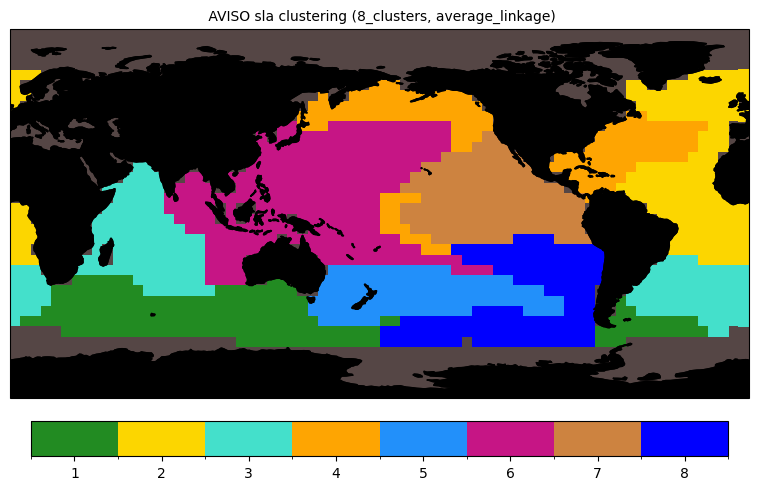

In [418]:
for num_clusters_range_it in num_clusters_arr[:1]:

    nan_dataset_to_fill = ds_dataframe_nonnan.to_xarray()
    nan_dataset_to_fill['zos'] = xr.DataArray(np.nan, coords=nan_dataset_to_fill['zos'].coords, 
                                dims=nan_dataset_to_fill['zos'].dims)
    nan_dataset_to_fill = nan_dataset_to_fill.mean(dim='time')
    
    comparison_matrix = 1-np.exp((-geographic_matrix)/(a_const_dist_matrix))*r
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    
    # Extract the cluster labels
    cluster_labels = fcluster(linkage_matrix, num_clusters_range_it, criterion='maxclust')
    
    unique_labels = np.unique(cluster_labels)
    list_to_array_slicing = np.array(keys_for_indexing)
    
    for label in unique_labels:
        cluster_points = np.where(cluster_labels == label)[0]  # Get the indices of points in the current cluster
        # in the code below when we index using 0 and 1 that is the array of the longitude and latitude coords. We must now put these into an xarray dataset.
        group_longitude = list_to_array_slicing[cluster_points, 1]
        group_latitude = list_to_array_slicing[cluster_points, 0]
    
        for point_iterator in range(len(group_latitude)):
            nan_dataset_to_fill.loc[{'longitude': group_longitude[point_iterator], 'latitude': group_latitude[point_iterator]}] = label
    
    from matplotlib.colors import ListedColormap, BoundaryNorm
    
    # Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
    sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
    center_value_longitude = 180
    sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude
    
    # Define the number of discrete values (clusters) you have
    
    # Create a discrete colormap
    cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])

    bounds = np.arange(1, num_clusters_range_it + 2) - .5
    norm = BoundaryNorm(bounds, cmap.N)
    
    # Plotting the cluster map
    projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
    fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})
    
    # Plot the data
    sla_dataset_to_plot.zos.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)
    
    # Add title and extent
    ax.set_title(f' AVISO sla clustering ({num_clusters_range_it}_clusters, {linkage_type}_linkage)', fontsize=10)
    ax.set_extent([-180, 180, -90, 90], crs=projection)
    
    # Add coastlines and features
    ax.coastlines(transform=projection)
    ax.add_feature(cfeature.LAND, zorder=10, color='black')
    ax.add_feature(cfeature.OCEAN, color='#554645')
    
    # Create colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=0.75)
    cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
    cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))
    
    # Save the figure
    plt.savefig(f'presentation_images/aviso_zosminmss_normed_{linkage_type}_linkage_{num_clusters_range_it}_clusters_a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')
    

### Sklearn Tests
- calinski harabasz, silhouette, dave_bouldin

In [98]:
silo_to_plot_ch = []
silo_to_plot = []
db_score = []

for num_clusters_silo in num_clusters_arr_silo:
    distance_matrix = comparison_matrix
    
    linkage_matrix = linkage(distance_matrix, method=linkage_type)
    cluster_labels = fcluster(linkage_matrix, num_clusters_silo, criterion='maxclust')

    # Calinksi Harabasz Score
    ch_avg = calinski_harabasz_score(distance_matrix, cluster_labels)
    silo_to_plot_ch.append(ch_avg)

    # Silhouette average
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silo_to_plot.append(silhouette_avg)

    dave_bould = davies_bouldin_score(distance_matrix, cluster_labels)
    db_score.append(dave_bould)

/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)
/vftmp/Theo.Avila/pid245068/ipykernel_11183/3937347572.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method=linkage_type)


#### Plotting Metrics

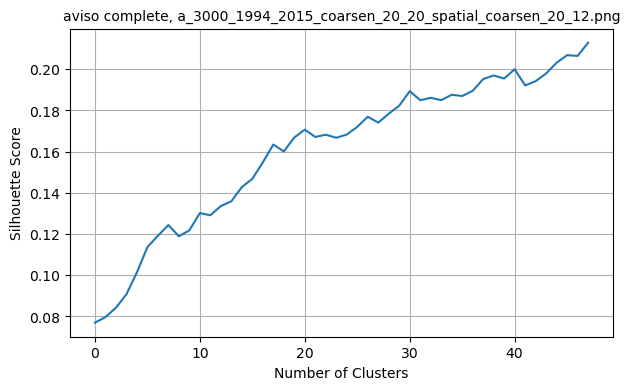

In [87]:
# Silhouette Plot
plt.plot(silo_to_plot)
plt.title(f'aviso {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_silo/avi_silo_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

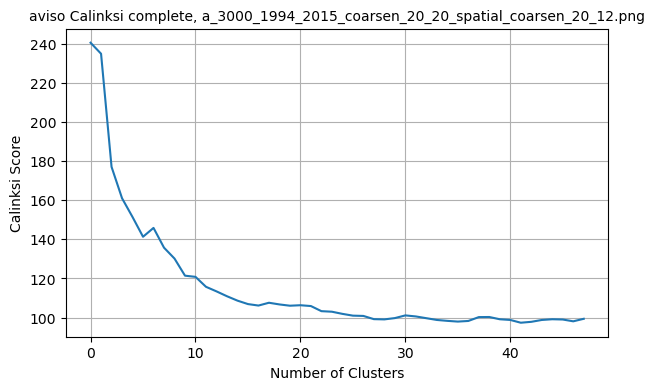

In [88]:
# Calinski Test
plt.plot(silo_to_plot_ch)
plt.title(f'aviso Calinksi {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Calinksi Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_calinski/avi_calinksi_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

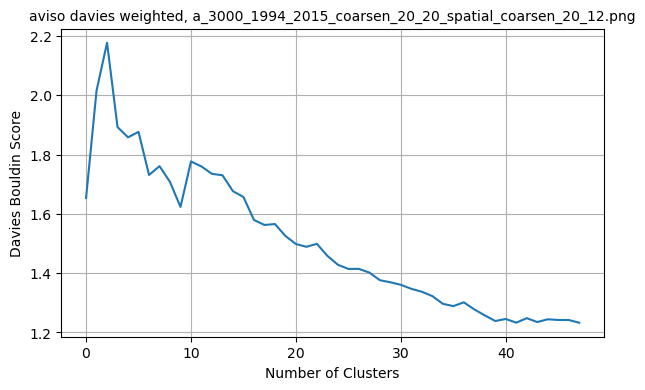

In [100]:
# Davies Bouldin Test
plt.plot(db_score)
plt.title(f'aviso davies {linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png', fontsize=10)
fig = plt.gcf()
fig.set_size_inches(7, 4) 
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
#plt.ylim(0.05, .275)  
plt.grid(True)

plt.savefig(f'aviso_maps/15_opt_clust_num/15_db/avi_db_{linkage_type}, a_{a_str}_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

### Dendrograms

/vftmp/Theo.Avila/pid4345/ipykernel_7574/2283628974.py:4: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')


Text(0.5, 1.0, 'Dendrogram AVISO average trunc (yr_1993_2015_spatialcoarse_20_tempsmooth_12)')

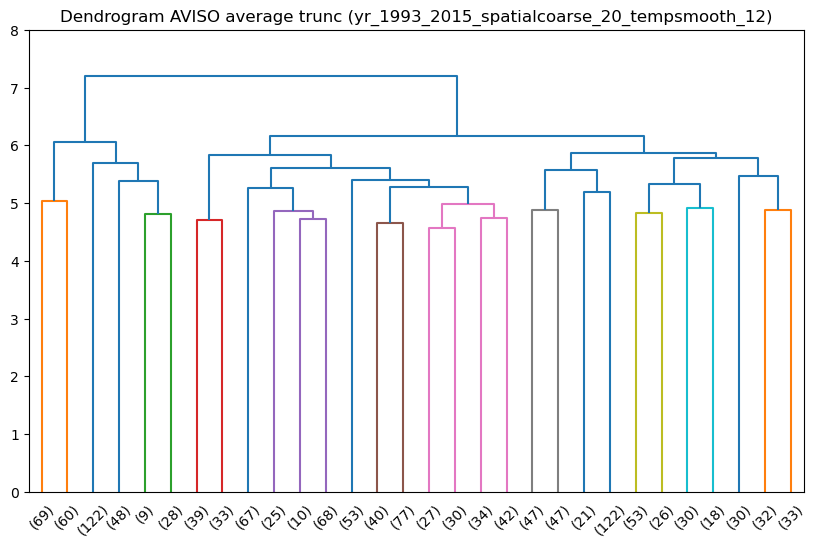

In [195]:
method_dend = 'average'

# Generate the dendrogram
dendrogram_dict = hierarchy.dendrogram(linkage(distance_matrix, method=method_dend), truncate_mode='lastp')
plt.ylim(0, 8)

# Change the figure size
fig = plt.gcf()
fig.set_size_inches(10, 6)  # Set the desired width and height

# Add a title
plt.title(f"Dendrogram AVISO {method_dend} trunc (yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window})")

# Show the dendrogram
#plt.savefig(f'aviso_maps/11_dendrograms/dendrogram_{method_dend}_yr_{start_year}_{end_year}_spatialcoarse_{coarsen_factor_longitude}_tempsmooth_{rolling_window}.png')

### Masking for Aggregate Cluster TS

#### Sea Level Anamoly Plots

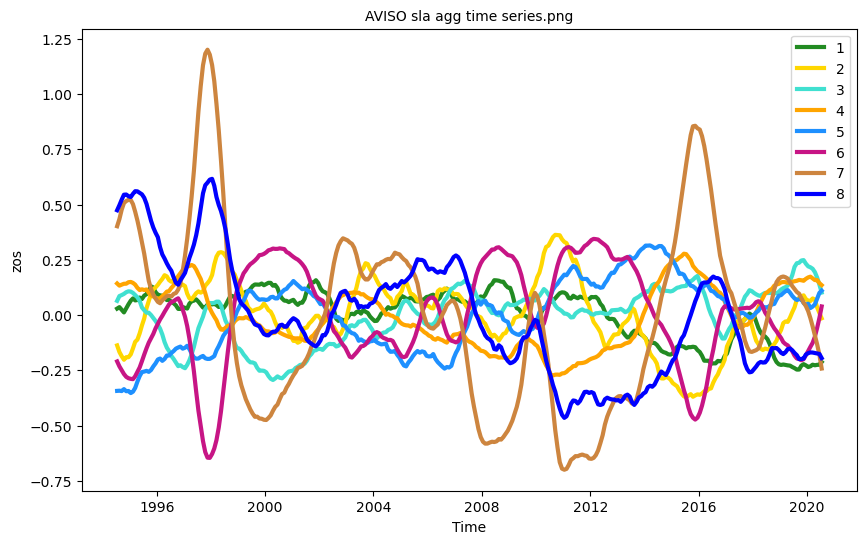

In [480]:
mask = nan_dataset_to_fill.copy(deep=True)

cmap = LinearSegmentedColormap.from_list("saturated_values", matplot_color_array[0:num_clusters])
#figure = plt.figure(figsize=(10, 6))

# Grouping each cluster and plotting

each_cluster_dataset_true, each_cluster_dataset_false = [], []
cluster_time_series_arr = []
idx = 0
for cluster_val in unique_labels:

    # Creating boolean based off of unique label, then applying so I have just the values for each cluster, could add to an array in order iterate through the others for covariance.
    boolean_mask_cluster = mask['zos'] == cluster_val
    cluster_i_masked_true = subset_Coarse_lat_lon_slice.where(boolean_mask_cluster).copy(deep=True)
    cluster_i_masked_false = subset_Coarse_lat_lon_slice.where(~boolean_mask_cluster).copy(deep=True)

    each_cluster_dataset_true.append(cluster_i_masked_true)
    each_cluster_dataset_false.append(cluster_i_masked_false)

    # Mean of each cluster in time from original. 
    cluster_i_masked_mean = cluster_i_masked_true.mean(dim=['longitude', 'latitude'])
    cluster_i_masked_mean.zos.plot(label=f'{cluster_val}', color=matplot_color_array[idx], linewidth=3)
    cluster_time_series_arr.append(cluster_i_masked_mean.zos)
    idx += 1
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()
plt.title(f'AVISO sla agg time series.png', fontsize=10)
#plt.savefig(f'presentation_images/ts_aviso_zosminmss_norm_{linkage_type}_linkage_{num_clusters_range_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}')
#plt.legend()
plt.show()

#### Correlation Grid for clusters

##### Loading climate indexes for correlation

In [74]:
basepath = '/work/Theo.Avila/0_climate_indices/'
index_file_paths = ['amo_monthly_10yrLP.data', 'nao_norm_nao_monthly_b5001_current_ascii.data', 'nina4_anom_enso.data', 
                    'oni_enso.data', 'pdo_timeseries_sstens.data', 'soi_enso.data','sam_new_1957_2007.data', 'npo.data']
index_names = ['amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'sam', 'npo']
index_values = [[], [], [], [], [], [], [], []]

for index_naming_it, index_path in enumerate(index_file_paths): 
    file_path = basepath + index_path
    print(index_names[index_naming_it])
    data_array = np.loadtxt(file_path)
    df_arr = pd.DataFrame(data_array.transpose())
    df = df_arr.iloc[1:, :]
    df.columns = list(range(int(df_arr[0][0]), int(df_arr[0][0]) + int(np.shape(df_arr)[1])))
    df = df.transpose().loc[start_year:end_year]
    df_new_years = np.reshape(df.values, (1, np.shape(df)[0] * np.shape(df)[1]))[0]
    
    data_array_index = xr.DataArray(df_new_years).rename(index_names[index_naming_it])
    data_array_index['dim_0'] = cluster_time_series_arr[0].time.values
    da_renamed = data_array_index.rename({'dim_0' : 'time'})
    index_values[index_naming_it] = da_renamed
    


amo
nao
enso4
oni
pdo
soi
sam
npo


In [75]:
# Adding indexes to array in order to plot correlation
for climate_mode in index_values:
    cluster_time_series_arr.append(climate_mode)
for i in range(len(cluster_time_series_arr)):
    cluster_time_series_arr[i] = cluster_time_series_arr[i].isel(time=slice(6, -5))

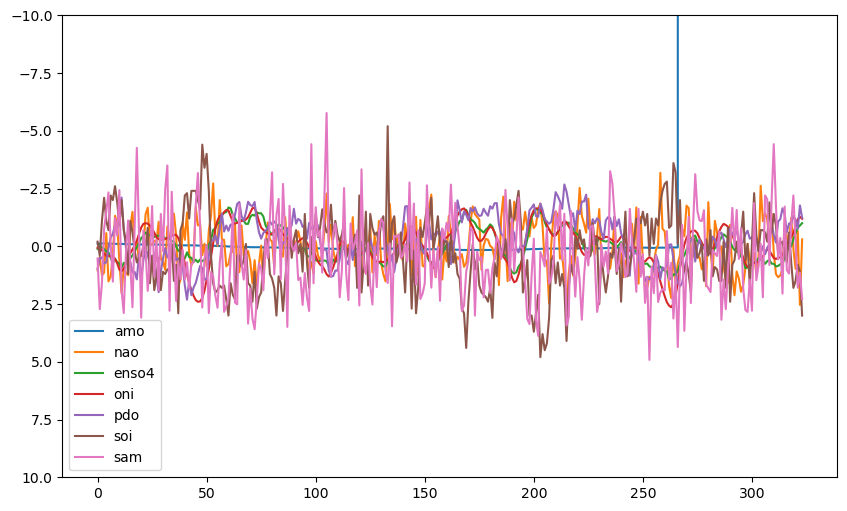

In [76]:

for climate_mode in index_values[:-1]:
    plt.plot(climate_mode,label=climate_mode.name)

plt.ylim(10, -10)
fig = plt.gcf()
fig.set_size_inches(10, 6)
plt.legend()

In [77]:
zero_matrix_for_ttest_corr = np.zeros((len(cluster_time_series_arr), len(cluster_time_series_arr)))
zero_matrix_for_ttest_pval = np.zeros((len(cluster_time_series_arr), len(cluster_time_series_arr)))

for i, pair1 in enumerate(cluster_time_series_arr):
    for j, pair2 in enumerate(cluster_time_series_arr):
        single_correlation, single_p_value = stats.pearsonr(pair1.values, pair2.values)
        zero_matrix_for_ttest_corr[i][j] = single_correlation
        zero_matrix_for_ttest_pval[i][j] = single_p_value

# mask for statistically insignificant p-values
zero_matrix_for_ttest_pval[np.tril_indices(zero_matrix_for_ttest_pval.shape[0], -1)] = np.nan
correlation_matrix_clusters_pd_p = pd.DataFrame(zero_matrix_for_ttest_pval)

##### Plotting Correlation Maps

In [9]:
zero_matrix_for_ttest_corr[np.tril_indices(zero_matrix_for_ttest_corr.shape[0], -1)] = np.nan
correlation_matrix_clusters_pd = pd.DataFrame(zero_matrix_for_ttest_corr)
correlation_matrix_clusters_pd.columns = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd.index = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd_p.columns = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
correlation_matrix_clusters_pd_p.index = [1,2,3,4,5,6,7,8,9,10, 'amo', 'nao', 'enso4', 'oni', 'pdo', 'soi', 'npo', 'sam']
extent_val = [.5, 18.5, 18.5, .5]
correlation_matrix_clusters_pd = correlation_matrix_clusters_pd.where(correlation_matrix_clusters_pd_p <= 0.05)
plt.imshow(correlation_matrix_clusters_pd, vmin=-1, vmax=1, extent = extent_val, cmap='coolwarm')
plt.xticks(ticks=np.arange(1, 19, 1), labels=correlation_matrix_clusters_pd.columns, rotation=90, ha='right')
plt.xlim(0.5, 18.5)
plt.yticks(ticks=np.arange(1, 19, 1), labels=correlation_matrix_clusters_pd.columns, ha='right')
plt.ylim(18.5, .5)

plt.xlabel('cluster number / modes')
plt.ylabel('cluster number / modes')
plt.title('AVISO sla cluster modes timeseries Correlation')
plt.colorbar()
#plt.savefig(f'aviso_maps/21_alltime/corr_map_aviso_zosminmss_norm_clim_modes{linkage_type}_linkage_{num_clusters_range_it}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}.png')

NameError: name 'zero_matrix_for_ttest_corr' is not defined

#### Volume redistribution per TM14 plots
$$
\text{rate of redistribution} = \frac{A_2}{A_T} \frac{d n_2}{d t} - \frac{A_1}{A_T} \frac{d n_1}{d t}
$$
$\text{in this case A is area of cluster and the derivative is the rate of change of sla}$

In [481]:
mask = nan_dataset_to_fill.copy(deep=True)

subtracted_redistribution_timeseries_arr = []

for i, cluster_val1 in enumerate(unique_labels):
    
    boolean_mask_cluster_1 = mask['zos'] == cluster_val1
    cluster_i_masked_1 = subset_Coarse_lat_lon_slice.where(boolean_mask_cluster_1).copy(deep=True)
    area_1 = (cluster_i_masked_1['areacello'] * cluster_i_masked_1['wet']).mean(dim=['longitude', 'latitude'])
    sla_1 = area_1 * cluster_i_masked_1['zos']
    cluster_i_masked_mean_1 = sla_1.mean(dim=['longitude', 'latitude'])
    
    for j, iterative_cluster_val2 in enumerate(unique_labels):
        
        boolean_mask_cluster_2 = mask['zos'] == iterative_cluster_val2
        cluster_i_masked_2 = subset_Coarse_lat_lon_slice.where(boolean_mask_cluster_2).copy(deep=True)
        area_2 = (cluster_i_masked_2['areacello'] * cluster_i_masked_2['wet']).mean(dim=['longitude', 'latitude'])
        sla_2 = area_2 * cluster_i_masked_2['zos']
        cluster_i_masked_mean_2 = sla_2.mean(dim=['longitude', 'latitude'])
        A_total = area_1 + area_2
        rate_of_redistribution = (area_2.values.item() / A_total.values.item()) * (np.gradient(cluster_i_masked_mean_2)) - \
                                    (area_1.values.item() / A_total.values.item()) * (np.gradient(cluster_i_masked_mean_1))
        rate_of_redistribution_smoothed = np.array(pd.DataFrame(rate_of_redistribution).rolling(window=rolling_window, center=True).mean())
        rate_of_redistribution_smoothed = np.reshape(rate_of_redistribution_smoothed, len(rate_of_redistribution_smoothed))
        subtracted_redistribution_timeseries_arr.append(rate_of_redistribution_smoothed)


##### Correlation with climate modes for all points

In [482]:
basepath = '/work/Theo.Avila/0_climate_indices/'
index_file_paths = ['amo_monthly_10yrLP.data', 'nao_norm_nao_monthly_b5001_current_ascii.data', 'nina4_anom_enso.data', 
                    'oni_enso.data', 'soi_enso.data', 'pdo_timeseries_sstens.data', 'sam_new_1957_2007.data', 'npo_fixed.data']
index_names = ['amo', 'nao', 'enso4', 'oni', 'soi', 'pdo', 'sam', 'npo']
index_values = [[], [], [], [], [], [], [], []]

for index_naming_it, index_path in enumerate(index_file_paths): 
    file_path = basepath + index_path
    print(index_names[index_naming_it])
    if index_names[index_naming_it] == 'npo':
        data_array = np.loadtxt(file_path)
        df_arr = pd.DataFrame(data_array.transpose())

        column_arr_years = []
        for year_month_ in df_arr.loc[0]:
            year_npo = str(year_month_)[:4]
            month_npo = str(year_month_)[4:6]
            column_arr_years.append(str(year_npo))
        df_arr.columns = column_arr_years
        df_arr = df_arr.loc[1]
        df_arr = pd.DataFrame(df_arr).loc[str(start_year):str(end_year)]
        df_arr_smoothed = np.array(pd.DataFrame(df_new_years).rolling(window=rolling_window, center=True).mean())
        df_new_years_smoothed = np.reshape(np.array(df_arr_smoothed), len(df_arr_smoothed))
        df_new_years_delta = np.gradient(df_new_years_smoothed)
        
        df_new_years_delta_smoothed = np.array(pd.DataFrame(df_new_years_delta).rolling(window=rolling_window, center=True).mean())
        df_new_years_delta_smoothed_shaped = np.reshape(df_new_years_delta_smoothed, (len(df_new_years_delta_smoothed)))

        subtracted_redistribution_timeseries_arr.append(df_new_years_delta_smoothed_shaped)
    
    else:
        data_array = np.loadtxt(file_path)
        df_arr = pd.DataFrame(data_array.transpose())
        df = df_arr.iloc[1:, :]
        df.columns = list(range(int(df_arr[0][0]), int(df_arr[0][0]) + int(np.shape(df_arr)[1])))
        df = df.transpose().loc[start_year:end_year]
        df_new_years = np.reshape(df.values, (1, np.shape(df)[0] * np.shape(df)[1]))[0]
        df_new_years_days = pd.DataFrame(df_new_years)
        df_new_years_smoothed = np.array(pd.DataFrame(df_new_years_days).rolling(window=rolling_window, center=True).mean())
        df_smoothed_reshaped = np.reshape(df_new_years_smoothed, (len(df_new_years_smoothed)))
        df_new_years_delta = np.gradient(df_smoothed_reshaped)
        df_new_years_delta_smoothed = np.array(pd.DataFrame(df_new_years_delta).rolling(window=rolling_window, center=True).mean())
        df_new_years_delta_smoothed_shaped = np.reshape(df_new_years_delta_smoothed, (len(df_new_years_delta_smoothed)))
        subtracted_redistribution_timeseries_arr.append(df_new_years_delta_smoothed_shaped) 
    

amo
nao
enso4
oni
soi
pdo
sam
npo


##### correlation matrix for volume redistribution and plotting

/vftmp/Theo.Avila/pid134013/ipykernel_160337/3345080149.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  single_correlation_distribution, single_p_value_distribution = stats.pearsonr(pair1[13:-11], pair2[13:-11])


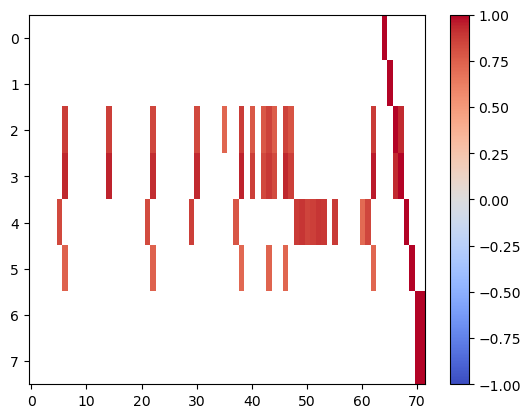

In [484]:
zero_matrix_for_ttest_corr = np.zeros((len(subtracted_redistribution_timeseries_arr), len(subtracted_redistribution_timeseries_arr)))
zero_matrix_for_ttest_pval = np.zeros((len(subtracted_redistribution_timeseries_arr), len(subtracted_redistribution_timeseries_arr)))
for i, pair1 in enumerate(subtracted_redistribution_timeseries_arr):
    for j, pair2 in enumerate(subtracted_redistribution_timeseries_arr):
        single_correlation_distribution, single_p_value_distribution = stats.pearsonr(pair1[13:-11], pair2[13:-11])
        zero_matrix_for_ttest_corr[i][j] = single_correlation_distribution
        zero_matrix_for_ttest_pval[i][j] = single_p_value_distribution

zero_matrix_for_ttest_pval_pd, zero_matrix_for_ttest_corr_pd = pd.DataFrame(zero_matrix_for_ttest_pval), pd.DataFrame(zero_matrix_for_ttest_corr)
zero_matrix_for_ttest_corr_pd = zero_matrix_for_ttest_corr_pd.where(zero_matrix_for_ttest_pval_pd <= .05)
high_corr_values = zero_matrix_for_ttest_corr_pd.tail(8).where(zero_matrix_for_ttest_corr_pd.tail(8) >= .7)
plt.imshow(high_corr_values, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()
#low_corr_values = zero_matrix_for_ttest_corr_pd.tail(8).where(zero_matrix_for_ttest_corr_pd.tail(8) <= -.8)
#plt.imshow(low_corr_values, aspect='auto', vmin=-1, vmax=1, cmap='coolwarm')

In [485]:
corr_df_for_keys, tup_ar = pd.DataFrame(high_corr_values), []
for i in corr_df_for_keys:
    for j, nonnan in enumerate(corr_df_for_keys[i].values):
        if not np.isnan(nonnan):
            #print(f'{nonnan} {i}, {j+num_clusters**2}')
            tup_return = [i, j+num_clusters**2]
            tup_ar.append(tup_return)

original_time_series_tobe_dicted = pd.DataFrame(subtracted_redistribution_timeseries_arr)

In [499]:
pdo_tup = []
for it, valuation in enumerate(high_corr_values.loc[69].values):
    if not np.isnan(valuation):
        pdo_tup.append([it, 69])

In [502]:
pdo_tup

[[6, 69], [22, 69], [38, 69], [43, 69], [46, 69], [62, 69], [69, 69]]

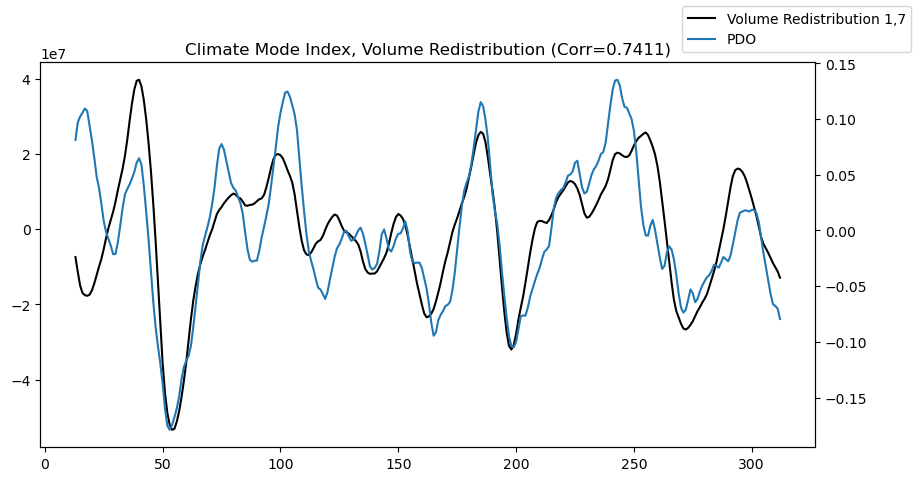

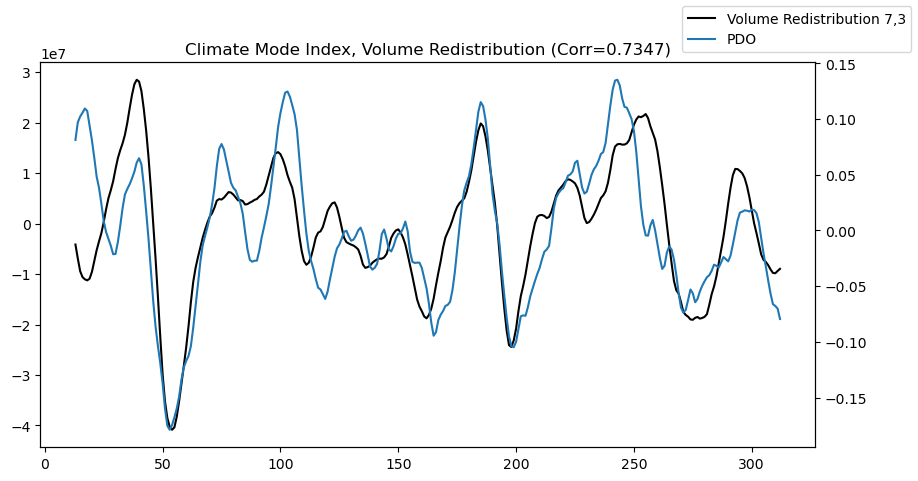

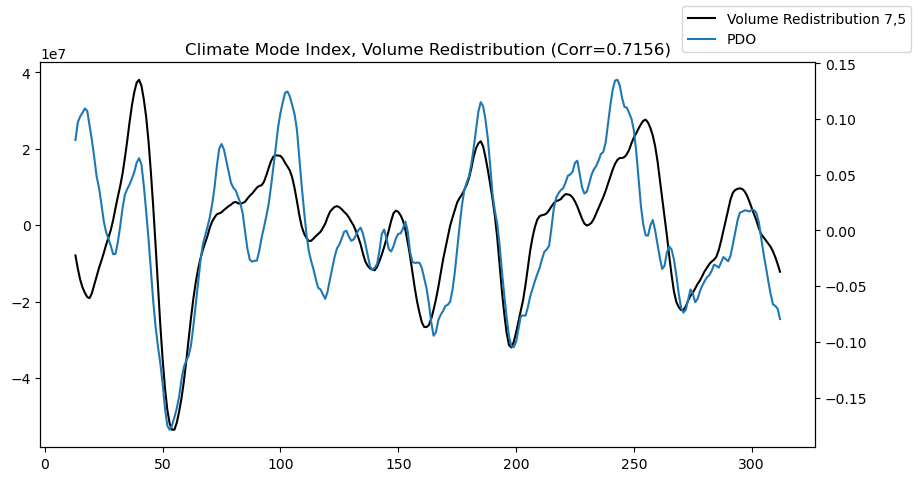

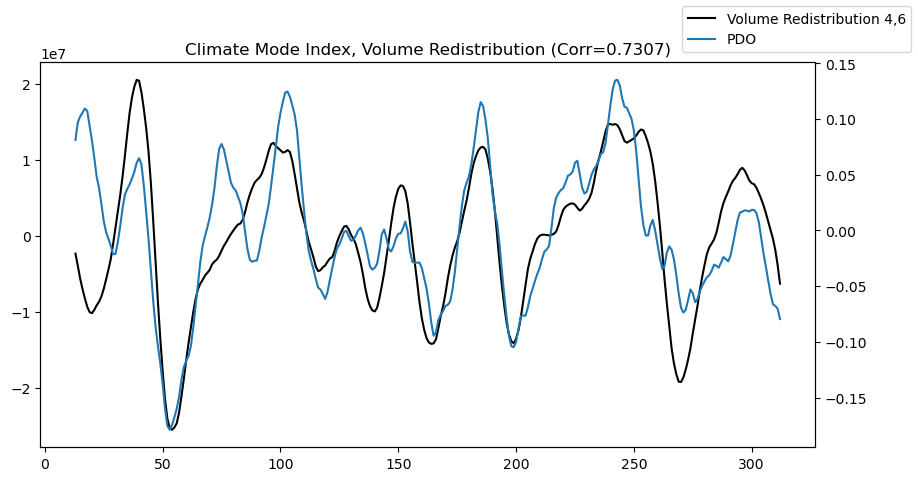

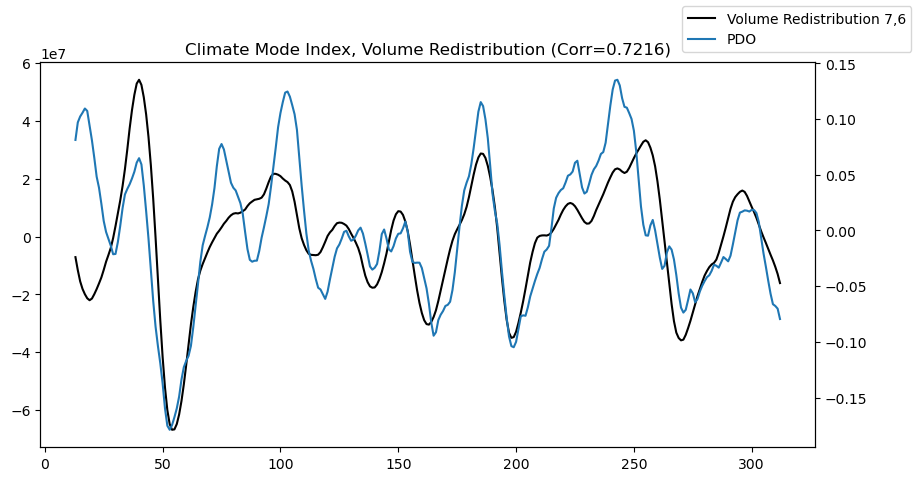

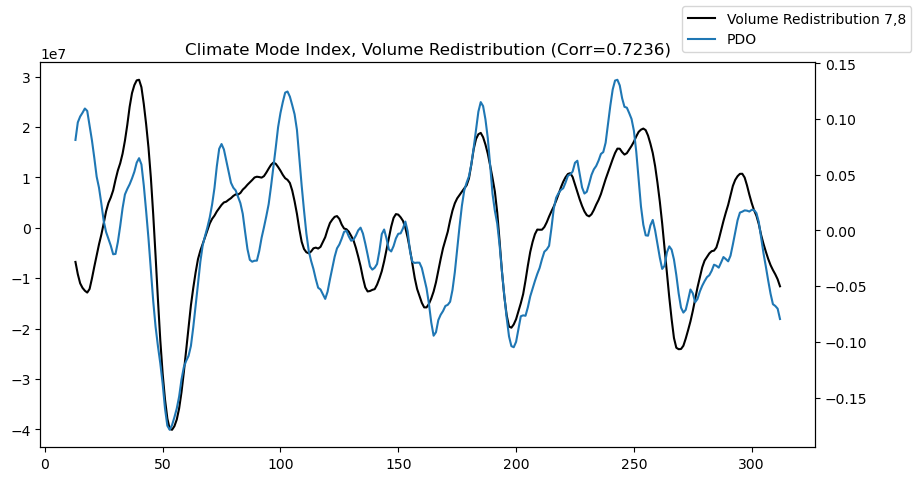

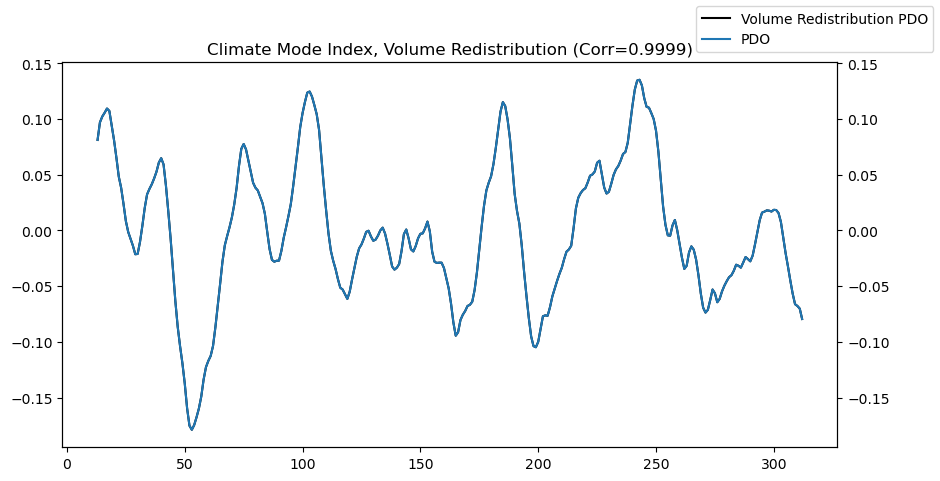

In [504]:
for tuples in pdo_tup:
    
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax2 = ax1.twinx()
    val_minus = tuples[0]
    climate_index = tuples[1]
    
    if val_minus < 64:
        if len(str(val_minus)) == 1:
            volume_redistribution_clusters = f'1,{int(val_minus+1)}'
        else:
            first_cluster = val_minus % num_clusters
            second_cluster = val_minus // num_clusters
            volume_redistribution_clusters = f'{first_cluster+1},{second_cluster+1}'
    elif val_minus >= 64:
        volume_redistribution_clusters = f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}'
        
    
    
    ax1.plot(original_time_series_tobe_dicted.loc[val_minus], color='black', label=f'Volume Redistribution {volume_redistribution_clusters}')
    plt.plot(original_time_series_tobe_dicted.loc[climate_index], label=f'{index_names[int(str(climate_index- num_clusters**2)[-1:])].upper()}')
    
    fig.legend(loc='upper right')
    corr_ts = str(np.corrcoef(original_time_series_tobe_dicted.loc[val_minus].values[13:-11], original_time_series_tobe_dicted.loc[climate_index].values[13:-11])[0][1])[:6]
    
    plt.title(f'Climate Mode Index, Volume Redistribution (Corr={corr_ts})')
    #plt.savefig(f'aviso_maps/22_all_mode_plots/vol_redist_smooothed_{volume_redistribution_clusters}_{index_names[int(str(climate_index)[-1:])]}_')

### Intra Cluster Covariance

In [505]:
intra_cov_ar = []

for count, inv_cluster_true in enumerate(each_cluster_dataset_true):

    # INtra cluster variance
    inv_cluster_true = inv_cluster_true.zos
    da_flat_cov = inv_cluster_true.stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov = da_flat_cov.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix = da_flattened_cov.to_pandas().T.cov().copy(deep=True)
    
    averaged_for_each_pt_cov = cov_matrix.mean(axis=0).copy(deep=True)
    da_flat_cov.load()
    # Unstack the data
    unstack_data = averaged_for_each_pt_cov.unstack().copy(deep=True)
    
    cluster_intra_cluster_filled = inv_cluster_true.mean(dim='time').copy(deep=True)
    cluster_intra_cluster_filled = cluster_intra_cluster_filled.fillna(np.nan)

    # Inner cluster variance now
    each_cluster_dataset_false[count] = each_cluster_dataset_false[count].zos
    da_flat_cov_false = each_cluster_dataset_false[count].stack(location=('latitude', 'longitude')).transpose('location', 'time').copy(deep=True)
    da_flattened_cov_false = da_flat_cov_false.dropna(dim='location', how='all').copy(deep=True)
    cov_matrix_false = da_flattened_cov_false.to_pandas().T.copy(deep=True)
    da_flat_cov_false.load()
    
    for longitude in unstack_data.columns:
        # Iterate over the index values in "unstack_data"
        print(longitude)
        for latitude in unstack_data.index:
            
            # Access the specific cell in "intra_cov" using index and column values
            unstack_intra_cluster_cov = unstack_data.loc[latitude, longitude]

            unstack_data_values = da_flat_cov.loc[{'latitude': latitude, 'longitude': longitude}].values
            
            cov_matrix_false_copy_for_fill = cov_matrix_false.copy(deep=True)
            cov_matrix_false_copy_for_fill[latitude, longitude] = unstack_data_values
            cov_matrix_false_meaned = cov_matrix_false_copy_for_fill.cov().mean(axis=0)
            resultant_cov_denom_mean = cov_matrix_false_meaned[latitude, longitude]
            cluster_intra_cluster_filled.loc[latitude, longitude] = np.abs(unstack_intra_cluster_cov / resultant_cov_denom_mean)

    
    

    print(count)
    intra_cov_ar.append(cluster_intra_cluster_filled)

-72.5
-67.5
-62.5
112.5
117.5
122.5
127.5
132.5
137.5
142.5
147.5
152.5
157.5
162.5
167.5
172.5
177.5
-57.5
-52.5
-47.5
-42.5
-37.5
-32.5
-27.5
-22.5
27.5
32.5
37.5
42.5
47.5
52.5
57.5
62.5
67.5
72.5
77.5
82.5
87.5
92.5
97.5
102.5
107.5
-177.5
-172.5
7.5
12.5
17.5
22.5
0
-22.5
-17.5
-12.5
-7.5
-2.5
2.5
7.5
12.5
-37.5
-32.5
-27.5
-42.5
-47.5
-57.5
-52.5
-62.5
1
-17.5
-12.5
-22.5
-7.5
-2.5
2.5
-52.5
-47.5
-42.5
-37.5
-32.5
-27.5
7.5
12.5
-57.5
17.5
67.5
72.5
77.5
82.5
87.5
92.5
97.5
62.5
32.5
37.5
42.5
47.5
52.5
57.5
2
-157.5
-152.5
-147.5
-167.5
-162.5
-177.5
-172.5
-77.5
-82.5
-72.5
-67.5
-87.5
-62.5
-97.5
-92.5
-57.5
-52.5
-47.5
-42.5
-37.5
-32.5
-142.5
-137.5
-27.5
-132.5
-127.5
-22.5
142.5
147.5
152.5
157.5
162.5
167.5
172.5
177.5
3
152.5
157.5
162.5
167.5
172.5
177.5
-177.5
-172.5
-167.5
-162.5
-157.5
-152.5
-147.5
-142.5
-137.5
-107.5
-102.5
-97.5
-92.5
147.5
-132.5
-127.5
-122.5
-117.5
-112.5
4
97.5
102.5
107.5
112.5
-142.5
-137.5
-132.5
-127.5
-177.5
-172.5
-167.5
-162.5
-157.5


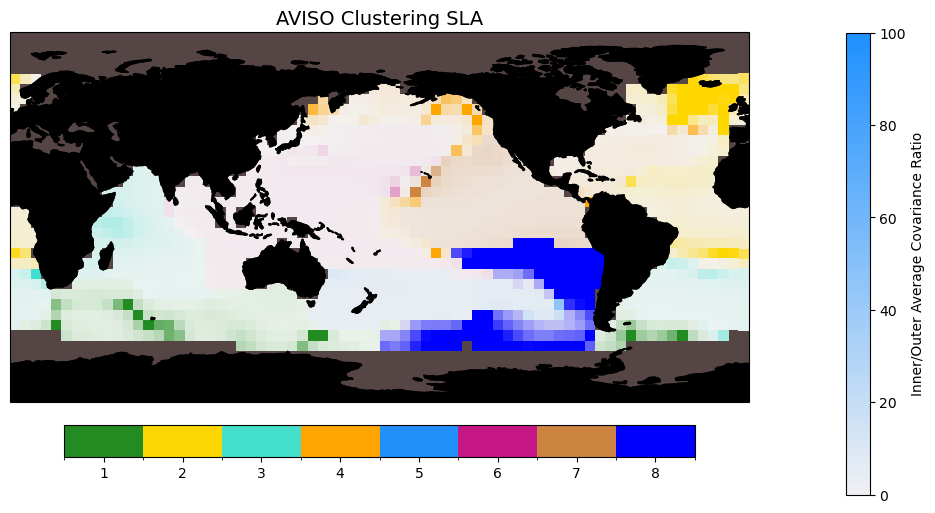

In [519]:

# Plotting the cluster map
center_value_longitude=180
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

vmax_val, vmin_val = 100, 0
for cmap_it, intra_cov in enumerate(intra_cov_ar):
    #intra_cov['longitude'] = intra_cov['longitude'] - 180
    intra_cov.plot(ax=ax, transform=projection, cmap=cmap_ar_div[cmap_it], add_colorbar=False, vmax=vmax_val, vmin=vmin_val)
    #intra_cov['longitude'] = intra_cov['longitude'] + 180

# Add title and extent
ax.set_title(f'AVISO Clustering SLA', fontsize=14)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_ar_div[4], norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.05, fraction=0.046)
cbar.set_label('Inner/Outer Average Covariance Ratio')

cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05, shrink=.75)
cbar.set_ticks(np.arange(1, num_clusters_range_it + 1))
cbar.set_ticklabels(np.arange(1, num_clusters_range_it + 1))

# Save the figure
plt.savefig(f'aviso_maps/23_cov_bounds_saturation_2100/cov_aviso_sla_norm{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}_intra_inner_cluster_covariance_vmax_{vmax_val}_{vmin_val}_.png')

### Uniform Color Plots

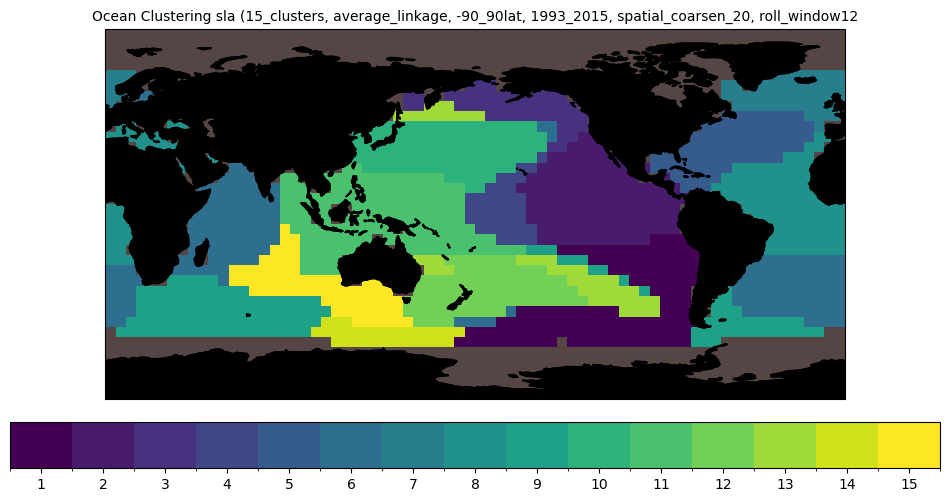

In [216]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load your dataset (assuming you already have nan_dataset_to_fill and sla_dataset_to_plot)
sla_dataset_to_plot = nan_dataset_to_fill.copy(deep=True)
center_value_longitude = 180
sla_dataset_to_plot['longitude'] = sla_dataset_to_plot['longitude'] - center_value_longitude

# Define the number of discrete values (clusters) you have

# Create a discrete colormap
cmap = plt.get_cmap('viridis', num_clusters)
bounds = np.arange(1, num_clusters + 2) - .5
norm = BoundaryNorm(bounds, cmap.N)

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

# Plot the data
sla_dataset_to_plot.sla.plot(ax=ax, transform=projection, cmap=cmap, norm=norm, add_colorbar=False)

# Add title and extent
ax.set_title(f'Ocean Clustering sla ({num_clusters}_clusters, {linkage_type}_linkage, {latitude_min}_{latitude_max}lat, {start_year}_{end_year}, spatial_coarsen_{smoothing_std}, roll_window{rolling_window}', fontsize=10)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

# Create colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', pad=0.05)
cbar.set_ticks(np.arange(1, num_clusters + 1))
cbar.set_ticklabels(np.arange(1, num_clusters + 1))

# Save the figure
plt.savefig(f'aviso_maps/sla_{linkage_type}_linkage_{num_clusters}_clusters_{latitude_min}_{latitude_max}latitude_{start_year}_{end_year}_coarsen_{coarsen_factor_latitude}_{coarsen_factor_longitude}_spatial_coarsen_{smoothing_std}_{rolling_window}')


### Map of Correlation at some point

In [ ]:
single_value_for_correlation = subset_Coarse_lat_lon_slice_initeration.sel(longitude=200, latitude=0, method='nearest')
fill_corr_map = subset_Coarse_lat_lon_slice_initeration.copy(deep=True)
print(len(subset_Coarse_lat_lon_slice_initeration.longitude))
for i, longitude in enumerate(subset_Coarse_lat_lon_slice_initeration.longitude):
    print(i)
    for latitude in subset_Coarse_lat_lon_slice_initeration.latitude:
        single_correlation = np.corrcoef(single_value_for_correlation, subset_Coarse_lat_lon_slice_initeration.sel(longitude = longitude, latitude = latitude))
        fill_corr_map.loc[dict(longitude=longitude, latitude=latitude)] = single_correlation[0, 1]
single_value_for_correlation = subset_Coarse_lat_lon_slice_initeration.sel(longitude=200, latitude=0, method='nearest')
single_value_for_correlation.plot()

cor_map_2pt5_200 = r.loc[(2.5, 202.5)].to_xarray()
center_value_longitude = 180
cor_map_2pt5_200['longitude'] = cor_map_2pt5_200['longitude'] - center_value_longitude

# Plotting the cluster map
projection = ccrs.PlateCarree(central_longitude=center_value_longitude)
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=center_value_longitude)})

cor_map_2pt5_200.plot(ax=ax, transform=projection, cmap='coolwarm', add_colorbar=True, cbar_kwargs={'label': 'Correlation'})

# Add title and extent
ax.set_title('Every Location Correlation with (2.5, 202.5)', fontsize=10)
ax.set_extent([-180, 180, -90, 90], crs=projection)

# Add coastlines and features
ax.coastlines(transform=projection)
#ax.add_feature(cfeature.LAND, zorder=10, color='black')
ax.add_feature(cfeature.OCEAN, color='#554645')

plt.savefig('aviso_maps/0_correlation_single_point_2pt5_202pt5.png')



### Imshow grids

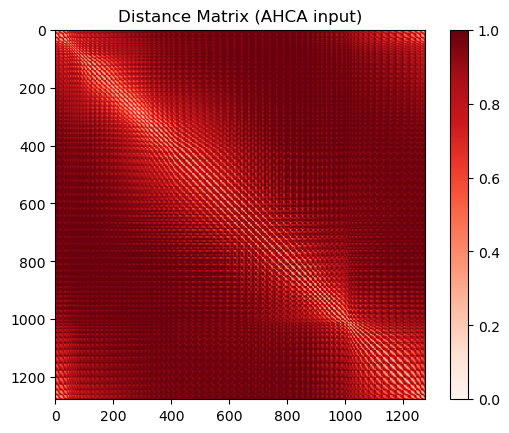

In [155]:
plt.imshow(comparison_matrix, cmap='Reds', vmin=0,vmax=1)
plt.title('Distance Matrix (AHCA input)')
plt.colorbar()
plt.savefig('aviso_maps/1_1_Distance_matrix')

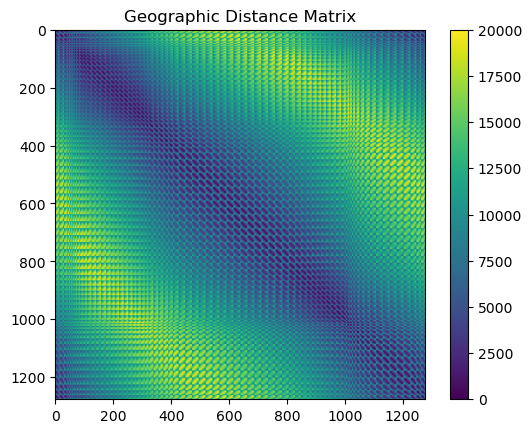

In [156]:
plt.imshow(-geo_distance_matrix, cmap='viridis')
plt.title('Geographic Distance Matrix')
plt.colorbar()
plt.savefig('aviso_maps/1_2_geographic_distance_matrix')

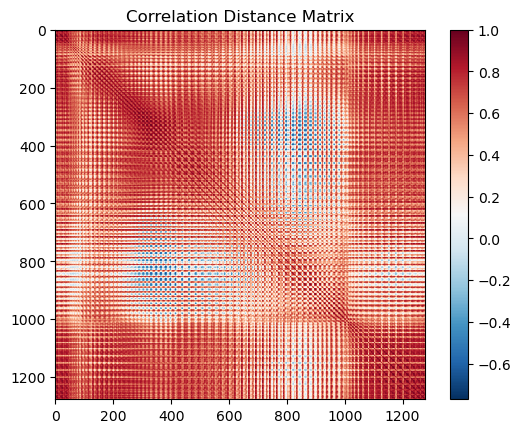

In [157]:
plt.imshow(correlation_matrix, cmap='RdBu_r')
plt.title('Correlation Distance Matrix')
plt.colorbar()
plt.savefig('aviso_maps/1_0_correlation_distance_matrix')

In [142]:
# now are the comparison i.e. the distance matrix of the haversine and other correlation method to show differences? 